# Binary Classification of NSL-KDD Dataset

By: Luis David Garcia

The dataset used is the NSL-KDD dataset, focusing specifcally on the DDoS
attacks and for binary classification. 

The train dataset is here: https://www.kaggle.com/datasets/hassan06/nslkdd?select=KDDTrain%2B.txt

The test dataset is here: https://www.kaggle.com/datasets/hassan06/nslkdd?select=KDDTest%2B.txt 

In [ ]:
import joblib
import time

import numpy as np
import pandas as pd

from IPython.display import display

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dense,
    Reshape,
    UpSampling1D,
    Bidirectional,
    LSTM,
    Dropout
)
from tensorflow.keras import regularizers

## Function to Get Train and Test Data

For an understanding of how we processed the data go to the
[Dataset Visualization and Preprocessing](#dataset-visualization-and-preprocessing-optional)
section.


In [ ]:
def get_processed_nslkdd_train_test(
    train_path = "../datasets/nsl-kdd/KDDTrain+.txt",
    test_path = "../datasets/nsl-kdd/KDDTest+.txt"
):
    """
    Get the processed NSL-KDD train and test data.

    Args:
        train_path (str): The path to the NSL-KDD train dataset.
        test_path (str): The path to the NSL-KDD test dataset.

    Returns:
        nslkdd_X_train (np.ndarray): The processed NSL-KDD train data.
        nslkdd_X_test (np.ndarray): The processed NSL-KDD test data.
        nslkdd_y_train (np.ndarray): The labels for the NSL-KDD train data.
        nslkdd_y_test (np.ndarray): The labels for the NSL-KDD test data.
        label_map (dict): A dictionary mapping the categorical features to their
                          respective encodings.
    """
    nslkdd_train, nslkdd_test = _read_train_test_data(train_path, test_path)
    nslkdd_train_binary, nslkdd_test_binary = _reduce_to_binary_ddos(
        nslkdd_train, nslkdd_test
    )
    nslkdd_train_binary, nslkdd_test_binary = _remove_unwanted_features(
        nslkdd_train_binary, nslkdd_test_binary
    )
    nslkdd_train_binary, nslkdd_test_binary, label_map = \
        _encode_categorical_features(
            nslkdd_train_binary, nslkdd_test_binary, nslkdd_train
        )
    nslkdd_X_train, nslkdd_X_test, nslkdd_y_train, nslkdd_y_test = \
        _get_train_test_split(
            nslkdd_train_binary, nslkdd_test_binary
        )
    nslkdd_X_train, nslkdd_X_test = _reduce_test_train_to_top_4_features(
        nslkdd_X_train, nslkdd_X_test
    )
    nslkdd_X_train, nslkdd_X_test = _scale_test_train(
        nslkdd_X_train, nslkdd_X_test
    )

    return nslkdd_X_train, nslkdd_X_test, nslkdd_y_train, nslkdd_y_test, label_map

def _read_train_test_data(train_path, test_path):
    columns = (['duration'
    ,'protocol_type'
    ,'service'
    ,'flag'
    ,'src_bytes'
    ,'dst_bytes'
    ,'land'
    ,'wrong_fragment'
    ,'urgent'
    ,'hot'
    ,'num_failed_logins'
    ,'logged_in'
    ,'num_compromised'
    ,'root_shell'
    ,'su_attempted'
    ,'num_root'
    ,'num_file_creations'
    ,'num_shells'
    ,'num_access_files'
    ,'num_outbound_cmds'
    ,'is_host_login'
    ,'is_guest_login'
    ,'count'
    ,'srv_count'
    ,'serror_rate'
    ,'srv_serror_rate'
    ,'rerror_rate'
    ,'srv_rerror_rate'
    ,'same_srv_rate'
    ,'diff_srv_rate'
    ,'srv_diff_host_rate'
    ,'dst_host_count'
    ,'dst_host_srv_count'
    ,'dst_host_same_srv_rate'
    ,'dst_host_diff_srv_rate'
    ,'dst_host_same_src_port_rate'
    ,'dst_host_srv_diff_host_rate'
    ,'dst_host_serror_rate'
    ,'dst_host_srv_serror_rate'
    ,'dst_host_rerror_rate'
    ,'dst_host_srv_rerror_rate'
    ,'attack'
    ,'level'])

    df_train=pd.read_csv(train_path, header=None, names=columns)
    df_test=pd.read_csv(test_path, header=None, names=columns)

    return df_train, df_test

def _reduce_to_binary_ddos(df_train, df_test):
    train_ddos = [
        "neptune",
        "smurf",
        "pod",
        "teardrop",
        "land",
        "back"
    ]

    test_ddos = [
        "apache2",
        "processtable",
        "mailbomb",
        "udpstorm",
    ]

    ddos_attacks = train_ddos + test_ddos
    allowed_samples = ddos_attacks + ["normal"]

    df_train_binary = df_train[df_train['attack'].isin(allowed_samples)].copy()
    df_train_binary['attack'] = df_train_binary['attack'].apply(
        lambda x: 'attack' if x != 'normal' else 'normal'
    )

    df_test_binary = df_test[df_test['attack'].isin(allowed_samples)].copy()
    df_test_binary['attack'] = df_test_binary['attack'].apply(
        lambda x: 'attack' if x != 'normal' else 'normal'
    )

    return df_train_binary, df_test_binary

def _remove_unwanted_features(df_train_binary, df_test_binary):
    non_directly_obtainable_features = [
        'hot',
        'num_failed_logins',
        'logged_in',
        'num_compromised',
        'root_shell',
        'su_attempted',
        'num_root',
        'num_file_creations',
        'num_shells',
        'num_access_files',
        'num_outbound_cmds',
        'is_host_login',
        'is_guest_login',
        'land',
        'level',   
        'urgent',
        'duration',
        'wrong_fragment',
        'count',
        'srv_count',
        'dst_host_srv_count',
        'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate',
        'dst_host_serror_rate',
        'dst_host_srv_serror_rate',
        'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate',
        'serror_rate',
        'srv_serror_rate',
        'rerror_rate',
        'srv_rerror_rate',
        'same_srv_rate',
        'diff_srv_rate',
        'srv_diff_host_rate',
        'dst_host_count',
        'protocol_type'
    ]

    X_train = df_train_binary.drop(non_directly_obtainable_features, axis=1)
    X_test = df_test_binary.drop(non_directly_obtainable_features, axis=1)

    return X_train, X_test

def _encode_categorical_features(X_train, X_test, df_train_binary):
    X_train['attack'] = X_train['attack'].map({'attack': 1, 'normal': 0})
    X_test['attack'] = X_test['attack'].map({'attack': 1, 'normal': 0})

    columns_to_encode = ['service', 'flag']
    label_map = {}

    for column in columns_to_encode:
        le = LabelEncoder()
        le.fit(df_train_binary[column])
        
        X_train[column] = le.transform(X_train[column])
        X_test[column] = X_test[column].apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
        
        label_map[column] = dict(zip(le.classes_, le.transform(le.classes_)))

        joblib.dump(le, f'{column}_encoder.joblib')

    return X_train, X_test, label_map

def _get_train_test_split(X_train, X_test):
    y_train = X_train['attack']
    X_train = X_train.drop('attack', axis=1)
    y_test = X_test['attack']
    X_test = X_test.drop('attack', axis=1)

    return X_train, X_test, y_train, y_test

def _reduce_test_train_to_top_4_features(X_train, X_test):
    top_4_features = ['service', 'flag', 'src_bytes','dst_bytes']
    X_train = X_train[top_4_features]
    X_test = X_test[top_4_features]
    
    return X_train, X_test

def _scale_test_train(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    joblib.dump(scaler, 'standard_scaler.joblib')

    return X_train, X_test

## (Optional) Dataset Visualization and Preprocessing

In [167]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

train_path = "../datasets/nsl-kdd/KDDTrain+.txt"
test_path = "../datasets/nsl-kdd/KDDTest+.txt"

df_train=pd.read_csv(train_path,header=None,names=columns)
df_test=pd.read_csv(test_path,header=None,names=columns)

In [168]:
# Training Set Preview
display(df_train.shape)
display(df_train.head())
display(df_train.info())
display(df_train['flag'].unique())

(125973, 43)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

None

array(['SF', 'S0', 'REJ', 'RSTR', 'SH', 'RSTO', 'S1', 'RSTOS0', 'S3',
       'S2', 'OTH'], dtype=object)

In [169]:
display(df_test.shape)
display(df_test.head())
display(df_test.info())

(22544, 43)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

None

In [134]:
# Check for duplicates
print("Duplicates in Train: " + str(df_train.duplicated().sum()))
print("Duplicates in Test: " + str(df_test.duplicated().sum()))

# Check for missing values
print("-----------------------------")
print("Rows with missing values - train: ")
display(df_train.isnull().sum())
print("Rows with missing values - test: ")
display(df_test.isnull().sum())

Duplicates in Train: 0
Duplicates in Test: 0
-----------------------------
Rows with missing values - train: 


duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

Rows with missing values - test: 


duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

### Reduce to only DDoS and Normal classes

In [135]:
# List of DDoS/DoS attacks for the training dataset
train_ddos = [
    "neptune",
    "smurf",
    "pod",
    "teardrop",
    "land",
    "back"
]

# List of DDoS/DoS attacks unique to the test dataset
test_ddos = [
    "apache2",
    "processtable",
    "mailbomb",
    "udpstorm",
]

# Combine the DDoS/DoS attacks
ddos_attacks = train_ddos + test_ddos

# Add "normal" to ddos_attacks for filtering
allowed_samples = ddos_attacks + ["normal"]

# Filter for DDoS/DoS attacks and normal samples in the training dataset
df_train_binary = df_train[df_train['attack'].isin(allowed_samples)].copy()

# Filter for DDoS/DoS attacks and normal samples in the test dataset
df_test_binary = df_test[df_test['attack'].isin(allowed_samples)].copy()

# Now, convert all attack types (DDoS/DoS) to 'attack'
df_train_binary['attack'] = df_train_binary['attack'].apply(
    lambda x: 'attack' if x != 'normal' else 'normal'
)

df_test_binary['attack'] = df_test_binary['attack'].apply(
    lambda x: 'attack' if x != 'normal' else 'normal'
)

In [170]:
# Helper function to plot bar count labels
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center',
            va='bottom'
        )

In [171]:
train_counts = df_train_binary['attack'].value_counts()
train_total = train_counts.sum()
train_percentages = train_counts / train_total * 100

print(f"Training set:")
print(f"Normal samples: {train_counts.iloc[0]} ({train_percentages.iloc[0]:.2f}%)")
print(f"Attack samples: {train_counts.iloc[1]} ({train_percentages.iloc[1]:.2f}%)")
print(f"Total samples: {train_total}")

Training set:
Normal samples: 67343 (59.45%)
Attack samples: 45927 (40.55%)
Total samples: 113270


In [138]:
test_counts = df_test_binary['attack'].value_counts()
test_total = test_counts.sum()
test_percentages = test_counts / test_total * 100

print(f"\nTest set:")
print(f"Normal samples: {test_counts.iloc[0]} ({test_percentages.iloc[0]:.2f}%)")
print(f"Attack samples: {test_counts.iloc[1]} ({test_percentages.iloc[1]:.2f}%)")
print(f"Total samples: {test_total}")


Test set:
Normal samples: 9711 (56.56%)
Attack samples: 7458 (43.44%)
Total samples: 17169


### Acquring only obtainable features from Networking Monitoring Tools

In [172]:
# "land," since this would have to be a check to see if src ip = dest ip
non_directly_obtainable_features = [
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'land',
    'level',   
    'urgent',
    'duration',
    'wrong_fragment',
    'count',
    'srv_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count'
]

# This feature is directly obtainable but very low selectKBest score
non_directly_obtainable_features += ['protocol_type']

X_train = df_train_binary.drop(non_directly_obtainable_features, axis=1)
X_test = df_test_binary.drop(non_directly_obtainable_features, axis=1)

In [173]:
# Grouping by attack type, service, and flag to find commonly associated combinations
grouped_X_train = X_train.groupby(['attack', 'service', 'flag']).size().reset_index(name='counts')
grouped_X_test = X_test.groupby(['attack', 'service', 'flag']).size().reset_index(name='counts')

# Saving grouped data to CSVs for reference
grouped_X_train.to_csv('grouped_X_train.csv', index=False)
grouped_X_test.to_csv('grouped_X_test.csv', index=False)

In [174]:
# Set 'attack' to 1 and 'normal' to 0 in both training and test sets
X_train['attack'] = X_train['attack'].map({'attack': 1, 'normal': 0})
X_test['attack'] = X_test['attack'].map({'attack': 1, 'normal': 0})

# Encode other categorical features
columns_to_encode = ['service', 'flag']
label_map = {}

for column in columns_to_encode:
    le = LabelEncoder()
    le.fit(df_train_binary[column])
    
    # Apply transformation to training and test sets
    X_train[column] = le.transform(X_train[column])
    X_test[column] = X_test[column].apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    
    # Save the label map for reference (this replaces saving the encoder itself)
    label_map[column] = dict(zip(le.classes_, le.transform(le.classes_)))

    # Save the label encoder for later use
    joblib.dump(le, f'{column}_encoder.joblib')

# Display the label map
for column, mapping in label_map.items():
    print(f"Mapping for {column}: {mapping}")

Mapping for service: {'IRC': 0, 'X11': 1, 'Z39_50': 2, 'auth': 3, 'bgp': 4, 'courier': 5, 'csnet_ns': 6, 'ctf': 7, 'daytime': 8, 'discard': 9, 'domain': 10, 'domain_u': 11, 'echo': 12, 'eco_i': 13, 'ecr_i': 14, 'efs': 15, 'exec': 16, 'finger': 17, 'ftp': 18, 'ftp_data': 19, 'gopher': 20, 'hostnames': 21, 'http': 22, 'http_443': 23, 'imap4': 24, 'iso_tsap': 25, 'klogin': 26, 'kshell': 27, 'ldap': 28, 'link': 29, 'login': 30, 'mtp': 31, 'name': 32, 'netbios_dgm': 33, 'netbios_ns': 34, 'netbios_ssn': 35, 'netstat': 36, 'nnsp': 37, 'nntp': 38, 'ntp_u': 39, 'other': 40, 'pop_2': 41, 'pop_3': 42, 'printer': 43, 'private': 44, 'red_i': 45, 'remote_job': 46, 'rje': 47, 'shell': 48, 'smtp': 49, 'sql_net': 50, 'ssh': 51, 'sunrpc': 52, 'supdup': 53, 'systat': 54, 'telnet': 55, 'tftp_u': 56, 'tim_i': 57, 'time': 58, 'urh_i': 59, 'urp_i': 60, 'uucp': 61, 'uucp_path': 62, 'vmnet': 63, 'whois': 64}
Mapping for flag: {'OTH': 0, 'REJ': 1, 'RSTO': 2, 'RSTR': 3, 'S0': 4, 'S1': 5, 'S2': 6, 'S3': 7, 'SF': 

In [175]:
# Split the data into features (x) and target (y)
y_train = X_train['attack']
X_train = X_train.drop('attack', axis=1)
y_test = X_test['attack']
X_test = X_test.drop('attack', axis=1)

In [176]:
# Ratio of Training to Testing Data
train_size = len(df_train_binary)
test_size = len(df_test_binary)

total_size = train_size + test_size

train_ratio = train_size / total_size
test_ratio = test_size / total_size

print(f"Training set: {train_size:,} samples ({train_ratio:.2%} of total)")
print(f"Testing set: {test_size:,} samples ({test_ratio:.2%} of total)")
print(f"Total dataset size: {total_size:,} samples")

Training set: 113,270 samples (86.84% of total)
Testing set: 17,169 samples (13.16% of total)
Total dataset size: 130,439 samples


### Feature Engineering

In [177]:
# SelectKBest for Top 4 Features
num_features = 4
top_4_features = SelectKBest(mutual_info_classif, k=num_features)
top_4_features.fit(X_train, y_train)
X_train.columns[top_4_features.get_support()]

Index(['service', 'flag', 'src_bytes', 'dst_bytes'], dtype='object')

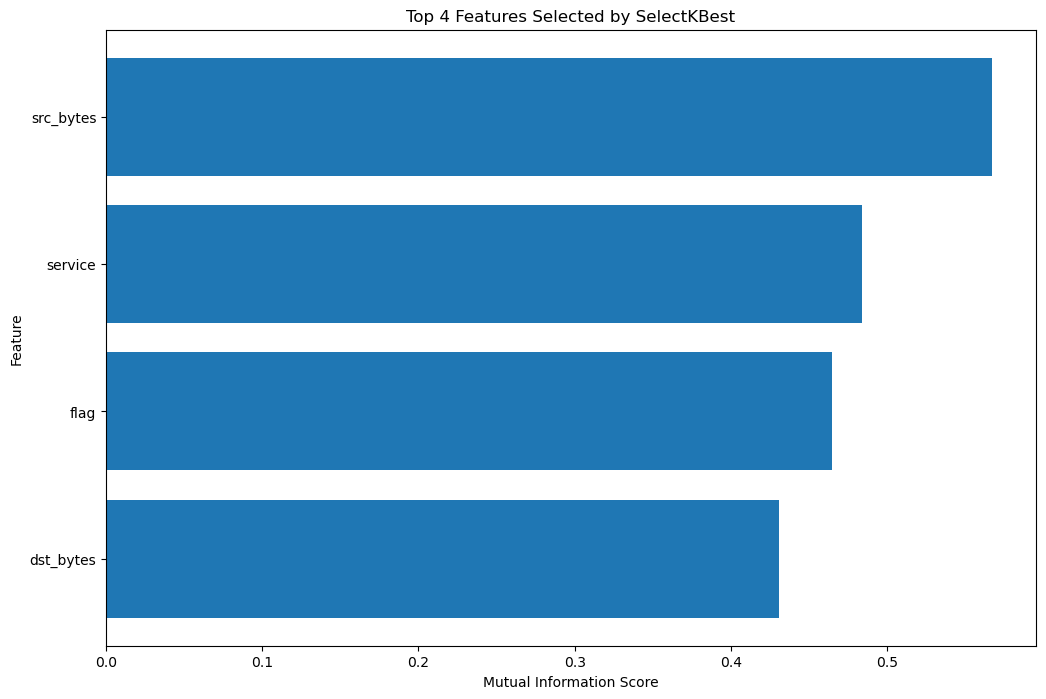

In [178]:
# Get the mask for the selected features
mask = top_4_features.get_support()

# Get the feature scores
feature_scores = top_4_features.scores_

# Get the selected feature names
selected_features = X_train.columns[mask]
selected_scores = feature_scores[mask]

# Create a DataFrame for plotting
df_top_features = pd.DataFrame({
    'Feature': selected_features,
    'Score': selected_scores
})

# Sort the DataFrame by scores in descending order
df_top_features = df_top_features.sort_values(by='Score', ascending=False)

# Plot the top features
plt.figure(figsize=(12, 8))
plt.barh(df_top_features['Feature'], df_top_features['Score'])
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top 4 Features Selected by SelectKBest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


In [179]:
top_4_features = ['service', 'flag', 'src_bytes','dst_bytes']

X_train = X_train[top_4_features]
X_test = X_test[top_4_features]

### Scale Data

In [180]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
sampled = False

# Save the scaler for later use
joblib.dump(scaler, 'standard_scaler.joblib')

['standard_scaler.joblib']

In [181]:
# Save processed X_train as a CSV file for reference
X_train_df = pd.DataFrame(X_train, columns=top_4_features)
X_train_df.to_csv('X_train_processed.csv', index=False)

## ML Results

Model XGBoost saved as xgboost_binary_model.joblib
--- XGBoost ---

Train Accuracy: 0.9945086960360201
Test Accuracy: 0.9296988758809482
Train Precision: 0.9905580700348658
Test Precision: 0.9795918367346939
Train Recall: 0.9959500947155269
Test Recall: 0.8559935639581657
Train F1 Score: 0.9932467645270564
Test F1 Score: 0.9136314847942755
Training Time: 0.2141 seconds
Prediction Time: 0.0029 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9711
           1       0.98      0.86      0.91      7458

    accuracy                           0.93     17169
   macro avg       0.94      0.92      0.93     17169
weighted avg       0.93      0.93      0.93     17169



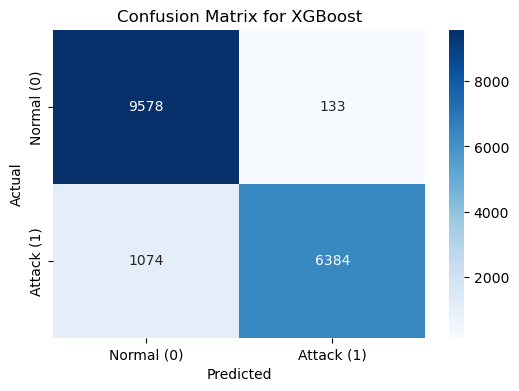

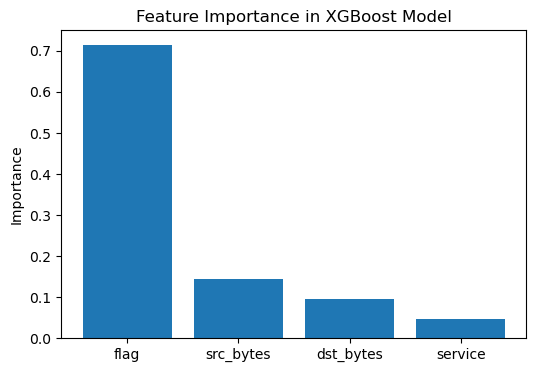

Model Logistic Regression saved as logistic_regression_binary_model.joblib
--- Logistic Regression ---

Train Accuracy: 0.9276507460051205
Test Accuracy: 0.8778612615760965
Train Precision: 0.9200659066619167
Test Precision: 0.9842818428184282
Train Recall: 0.899732183682801
Test Recall: 0.7304907481898633
Train F1 Score: 0.9097854445777694
Test F1 Score: 0.8386054029092588
Training Time: 0.0757 seconds
Prediction Time: 0.0030 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      9711
           1       0.98      0.73      0.84      7458

    accuracy                           0.88     17169
   macro avg       0.91      0.86      0.87     17169
weighted avg       0.90      0.88      0.87     17169



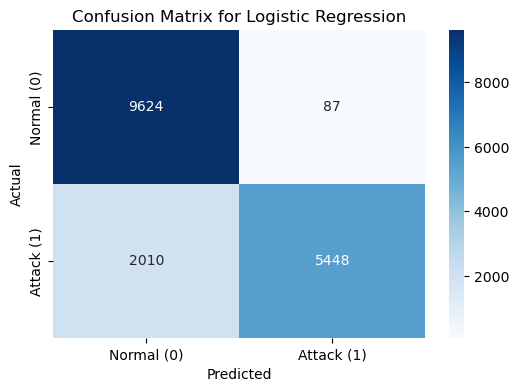

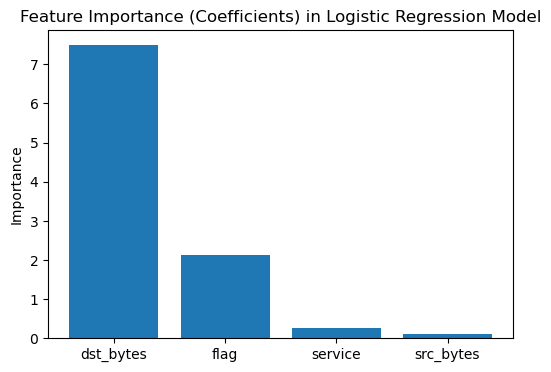

Model Random Forest saved as random_forest_binary_model.joblib
--- Random Forest ---

Train Accuracy: 0.9945616668138078
Test Accuracy: 0.9298736094123129
Train Precision: 0.9906655404673727
Test Precision: 0.9815214043732676
Train Recall: 0.995971868399852
Test Recall: 0.854652721909359
Train F1 Score: 0.9933116178067318
Test F1 Score: 0.913704128440367
Training Time: 1.8214 seconds
Prediction Time: 0.0351 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9711
           1       0.98      0.85      0.91      7458

    accuracy                           0.93     17169
   macro avg       0.94      0.92      0.93     17169
weighted avg       0.93      0.93      0.93     17169



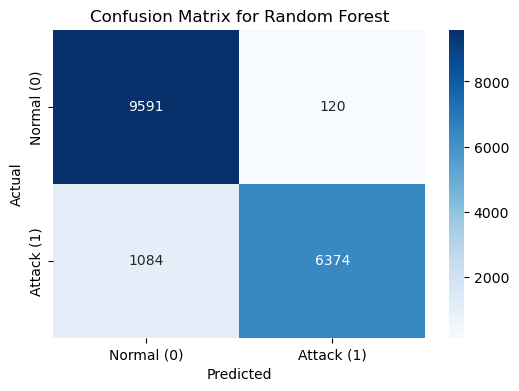

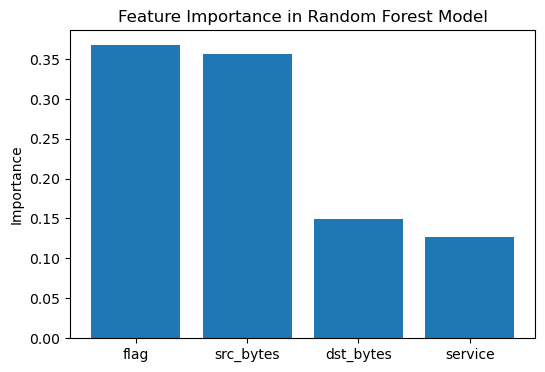

Model Decision Tree saved as decision_tree_binary_model.joblib
--- Decision Tree ---

Train Accuracy: 0.9945616668138078
Test Accuracy: 0.9305725435377715
Train Precision: 0.9906655404673727
Test Precision: 0.9815554872425454
Train Recall: 0.995971868399852
Test Recall: 0.856261732367927
Train F1 Score: 0.9933116178067318
Test F1 Score: 0.9146376396448009
Training Time: 0.0402 seconds
Prediction Time: 0.0005 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9711
           1       0.98      0.86      0.91      7458

    accuracy                           0.93     17169
   macro avg       0.94      0.92      0.93     17169
weighted avg       0.94      0.93      0.93     17169



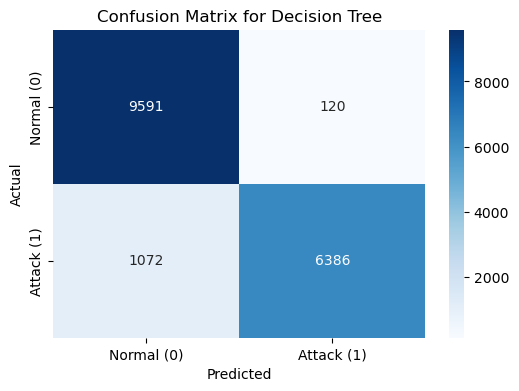

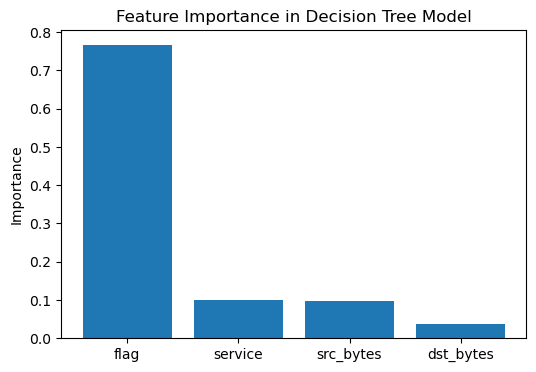

In [ ]:
X_train, X_test, y_train, y_test, label_map = get_processed_nslkdd_train_test()

models = {
    "XGBoost": XGBClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
}

# Feature names for plotting
feature_names = ['service', 'flag', 'src_bytes', 'dst_bytes']

# Train and evaluate each model
results = {}

for name, model in models.items():
    # Train the model
    start_train_time = time.time()
    model.fit(X_train, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Save the trained model
    model_filename = f"{name.replace(' ', '_').lower()}_binary_model.joblib"
    joblib.dump(model, model_filename)
    print(f"Model {name} saved as {model_filename}")

    # Predict on the training set for comparison with test set
    y_pred_train = model.predict(X_train)  

    # Predict on the test set
    start_pred_time = time.time()
    y_pred_test = model.predict(X_test)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time

    # Calculate evaluation metrics on the test set
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, average='binary', zero_division=1)
    recall_test = recall_score(y_test, y_pred_test, average='binary', zero_division=1)
    f1_test = f1_score(y_test, y_pred_test, average='binary', zero_division=1)

    # Calculate evaluation metrics on the training set
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, average='binary', zero_division=1)
    recall_train = recall_score(y_train, y_pred_train, average='binary', zero_division=1)
    f1_train = f1_score(y_train, y_pred_train, average='binary', zero_division=1)

    # Calculate confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred_test)
    cr = classification_report(y_test, y_pred_test)

    # Store the results
    results[name] = {
        "train_accuracy": accuracy_train,
        "train_precision": precision_train,
        "train_recall": recall_train,
        "train_f1": f1_train,
        "test_accuracy": accuracy_test,
        "test_precision": precision_test,
        "test_recall": recall_test,
        "test_f1": f1_test,
        "train_time": train_time,
        "pred_time": pred_time,
        "confusion_matrix": cm,
        "classification_report": cr
    }

    # Print evaluation metrics
    print(f'--- {name} ---\n')
    print(f'Train Accuracy: {accuracy_train}')
    print(f'Test Accuracy: {accuracy_test}')
    print(f'Train Precision: {precision_train}')
    print(f'Test Precision: {precision_test}')
    print(f'Train Recall: {recall_train}')
    print(f'Test Recall: {recall_test}')
    print(f'Train F1 Score: {f1_train}')
    print(f'Test F1 Score: {f1_test}')
    print(f'Training Time: {train_time:.4f} seconds')
    print(f'Prediction Time: {pred_time:.4f} seconds')
    print(f'\nClassification Report:\n{cr}')

    # Plot the confusion matrix for each
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', \
                xticklabels=['Normal (0)', 'Attack (1)'], \
                yticklabels=['Normal (0)', 'Attack (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Feature importance
    if name in ["Random Forest", "Decision Tree", "XGBoost"]:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        title = f"Feature Importance in {name} Model"

    elif name == "Logistic Regression":
        importances = np.abs(model.coef_[0])
        indices = np.argsort(importances)[::-1]
        title = f"Feature Importance (Coefficients) in {name} Model"

    # Plot the feature importances    
    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices])
    plt.ylabel("Importance")
    plt.show()

## DL Results

### CNN-LSTM

In [218]:
X_train, X_test, y_train, y_test, label_map = get_processed_nslkdd_train_test()

# Reshape x_train and x_test to 3D for CNN-LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # shape becomes (113270, 4, 1)
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) # shape becomes (17169, 4, 1)

print(f"X_train shape: {X_train.shape} -> {X_train_reshaped.shape}")
print(f"X_test shape: {X_test.shape} -> {X_test_reshaped.shape}")

X_train shape: (113270, 4) -> (113270, 4, 1)
X_test shape: (17169, 4) -> (17169, 4, 1)


In [184]:
cnn_lstm_model = tf.keras.models.Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(filters=128, kernel_size=2, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    MaxPooling1D(pool_size=1), 
    Conv1D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    # LSTM layers
    Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.3)),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
cnn_lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 3, 128)            384       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 2, 64)             16448     
                                                                 
 bidirectional_6 (Bidirectio  (None, 2, 128)           66048     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                      

In [ ]:
start_time = time.time()
cnn_lstm_model.fit(X_train_reshaped, 
                   y_train, 
                   epochs=50, 
                   batch_size=64,
                   validation_split=0.2,
                   callbacks=[lr_scheduler, early_stopping])
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.4f} seconds")

# Save the trained model to a file
cnn_lstm_model.save('cnn_lstm_binary_model.keras')  
print("Model saved as 'cnn_lstm_binary_model.keras'")

Epoch 1/50
1416/1416 [==============================] - 23s 15ms/step - loss: 0.2406 - accuracy: 0.9278 - val_loss: 0.1099 - val_accuracy: 0.9706 - lr: 5.0000e-04
Epoch 2/50
1416/1416 [==============================] - 22s 15ms/step - loss: 0.1096 - accuracy: 0.9697 - val_loss: 0.0869 - val_accuracy: 0.9716 - lr: 5.0000e-04
Epoch 3/50
1416/1416 [==============================] - 21s 15ms/step - loss: 0.0900 - accuracy: 0.9749 - val_loss: 0.0710 - val_accuracy: 0.9759 - lr: 5.0000e-04
Epoch 4/50
1416/1416 [==============================] - 21s 15ms/step - loss: 0.0811 - accuracy: 0.9761 - val_loss: 0.0679 - val_accuracy: 0.9799 - lr: 5.0000e-04
Epoch 5/50
1416/1416 [==============================] - 22s 16ms/step - loss: 0.0769 - accuracy: 0.9772 - val_loss: 0.0602 - val_accuracy: 0.9810 - lr: 5.0000e-04
Epoch 6/50
1416/1416 [==============================] - 21s 15ms/step - loss: 0.0724 - accuracy: 0.9776 - val_loss: 0.0591 - val_accuracy: 0.9809 - lr: 5.0000e-04
Epoch 7/50
1416/1416 [

In [186]:
# Make predictions on the test data
start_pred_time = time.time()
y_pred_prob = cnn_lstm_model.predict(X_test_reshaped)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time
print(f"Prediction time: {pred_time:.4f} seconds")

# Convert the predictions from probabilities to binary labels (0 or 1)
y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred_prob]


537/537 [==============================] - 1s 1ms/step
Prediction time: 1.0596 seconds


-- CNN-LSTM --
Test Accuracy: 0.93273
Test Precision: 0.98492
Test Recall: 0.85827
Test F1 Score: 0.91725

Classification Report:
              precision    recall  f1-score   support

      normal    0.90094   0.98991   0.94333      9711
      attack    0.98492   0.85827   0.91725      7458

    accuracy                        0.93273     17169
   macro avg    0.94293   0.92409   0.93029     17169
weighted avg    0.93742   0.93273   0.93200     17169



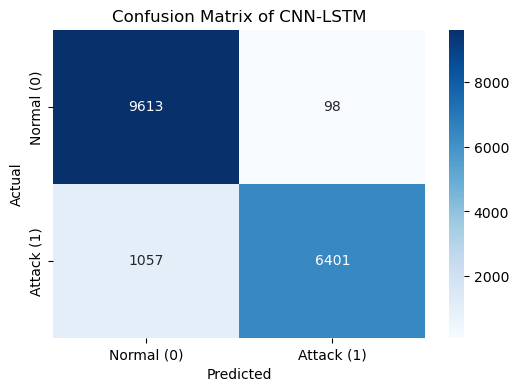

In [187]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the evaluation metrics
name = "CNN-LSTM"
print(f"-- {name} --")
print(f"Test Accuracy: {accuracy:.5f}")
print(f"Test Precision: {precision:.5f}")
print(f"Test Recall: {recall:.5f}")
print(f"Test F1 Score: {f1:.5f}")

# Print the classification report
print(f'\nClassification Report:')
print(classification_report(y_test, y_pred_binary, target_names=['normal', 'attack'], digits=5))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', \
            xticklabels=['Normal (0)', 'Attack (1)'], \
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix of {name}')
plt.show()

### Autoencoder-XGBoost

In [ ]:
X_train, X_test, y_train, y_test, label_map = get_processed_nslkdd_train_test()

# Reshape x_train and x_test to 3D for Autoencoder
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # shape becomes (113270, 4, 1)
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) # shape becomes (17169, 4, 1)

input_dim = X_train_reshaped.shape[1]
print(f"Input dimension: {input_dim}")

Input dimension: 4


In [ ]:
autoencoder = tf.keras.Sequential([
    Input(shape=(input_dim, 1)),
    Conv1D(32, 3, activation='relu', padding='same'),
    MaxPooling1D(2, padding='same'),
    Conv1D(16, 3, activation='relu', padding='same'),
    MaxPooling1D(2, padding='same'),
    Flatten(),
    Dense(16, activation='relu', name='bottleneck'),
    Dense(((input_dim // 4)) * 16, activation='relu'),
    Reshape(((input_dim // 4), 16)),
    UpSampling1D(2),
    Conv1D(16, 3, activation='relu', padding='same'),
    UpSampling1D(2),
    Conv1D(1, 8, activation='tanh', padding='same'),
])

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

print(autoencoder.summary())

encoder = tf.keras.Sequential(autoencoder.layers[:7])
encoder.build(input_shape=(None, input_dim, 1))
print(encoder.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 4, 32)             128       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 2, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 2, 16)             1552      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1, 16)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 16)                0         
                                                                 
 bottleneck (Dense)          (None, 16)              

In [ ]:
autoencoder_start_time = time.time()
autoencoder.fit(
    X_train_reshaped, 
    X_train_reshaped, 
    epochs=50, 
    batch_size=64, 
    shuffle=True, 
    validation_split=0.2,
)
autoencoder_end_time = time.time()
autoencoder_training_time = autoencoder_end_time - autoencoder_start_time

Epoch 1/50
1416/1416 [==============================] - 2s 1ms/step - loss: 0.3482 - val_loss: 1.3995
Epoch 2/50
1416/1416 [==============================] - 2s 1ms/step - loss: 0.3278 - val_loss: 1.3978
Epoch 3/50
1416/1416 [==============================] - 2s 1ms/step - loss: 0.3264 - val_loss: 1.3971
Epoch 4/50
1416/1416 [==============================] - 2s 1ms/step - loss: 0.3253 - val_loss: 1.3964
Epoch 5/50
1416/1416 [==============================] - 2s 1ms/step - loss: 0.3252 - val_loss: 1.3962
Epoch 6/50
1416/1416 [==============================] - 2s 1ms/step - loss: 0.3252 - val_loss: 1.3962
Epoch 7/50
1416/1416 [==============================] - 2s 1ms/step - loss: 0.3253 - val_loss: 1.3963
Epoch 8/50
1416/1416 [==============================] - 2s 1ms/step - loss: 0.3250 - val_loss: 1.3962
Epoch 9/50
1416/1416 [==============================] - 2s 1ms/step - loss: 0.3253 - val_loss: 1.3960
Epoch 10/50
1416/1416 [==============================] - 2s 1ms/step - loss: 0.324

In [212]:
# Encode the train and test data using the trained encoder
encoded_train = encoder.predict(X_train_reshaped)
encoded_test = encoder.predict(X_test_reshaped)

537/537 [==============================] - 0s 199us/step


In [213]:
# Save the encoder model
encoder.save('encoder_model.keras')

In [216]:
# Flatten the encoded data for training XGBoost
encoded_train_flat = encoded_train.reshape((encoded_train.shape[0], -1))
encoded_test_flat = encoded_test.reshape((encoded_test.shape[0], -1))

Model saved as ae_xgb_binary_model.joblib

--- AE-XGBoost ---
Test Accuracy: 0.92393
Test Precision: 0.97572
Test Recall: 0.84594
Test F1-Score: 0.90621
Training Time (seconds): 95.72759
Prediction Time (seconds): 0.00393

Classification Report:
              precision    recall  f1-score   support

           0    0.89265   0.98383   0.93602      9711
           1    0.97572   0.84594   0.90621      7458

    accuracy                        0.92393     17169
   macro avg    0.93418   0.91489   0.92111     17169
weighted avg    0.92873   0.92393   0.92307     17169



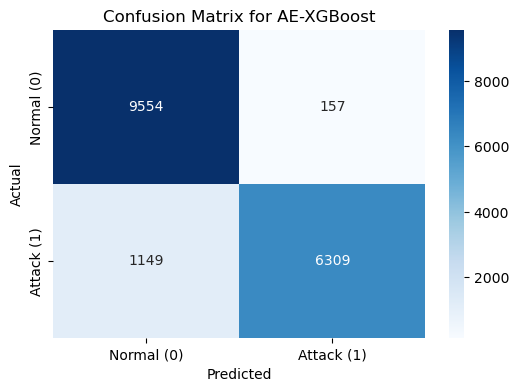

In [217]:
model = XGBClassifier()

# Train the model
start_train_time = time.time()
model.fit(encoded_train_flat, y_train, verbose=True)
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Save the trained AE-XGB model to a file
model_filename = "ae_xgb_binary_model.joblib"
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")

# Predict on the test set
start_pred_time = time.time()
y_pred = model.predict(encoded_test_flat)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=1)
recall = recall_score(y_test, y_pred, average='binary', zero_division=1)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=1)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, digits=5, zero_division=1)

# Store the results
results = {}
results["AE-XGBoost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "conf_matrix": cm,
    "class_report": cr,
    "train_time": train_time,
    "pred_time": pred_time
}

# Print evaluation metrics
name = "AE-XGBoost"
total_training_time = autoencoder_training_time + train_time
print(f'\n--- {name} ---')
print(f'Test Accuracy: {accuracy:.5f}')
print(f'Test Precision: {precision:.5f}')
print(f'Test Recall: {recall:.5f}')
print(f'Test F1-Score: {f1:.5f}')
print(f'Training Time (seconds): {total_training_time:.5f}')
print(f'Prediction Time (seconds): {pred_time:.5f}')
print(f'\nClassification Report:\n{cr}')

# Plot the confusion matrix 
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', \
            xticklabels=['Normal (0)', 'Attack (1)'], \
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {name}')
plt.show()